# Bonus track: Introducing Tensorflow

## Let us start climbing some abstraction layers using Tensorflow

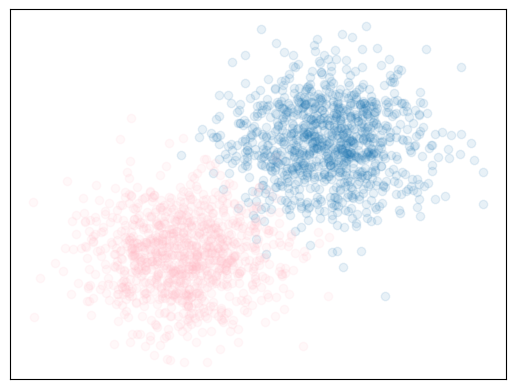

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Example dataset
N_samples_per_class = 1000
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),np.random.randn(N_samples_per_class, d_dimensions)+np.array([3,3])))
y = np.vstack((np.zeros((N_samples_per_class,1)),1.*np.ones((N_samples_per_class,1))))

x = x.astype('float32')
y = y.astype('float32')

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==0
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')
plt.xticks([])  
plt.yticks([]);

In [2]:
import tensorflow as tf

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.a = tf.Variable([[0.1],[0.2]],trainable=True,dtype=tf.float32)
        self.b = tf.Variable([0.3],trainable=True,dtype=tf.float32)

    def call(self, x):
        return tf.add(tf.matmul(x,self.a),tf.broadcast_to(self.b, [x.shape[0],1])) 

# Create an instance of the model
model = MyModel()

In [3]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [4]:
@tf.function
def train_step(xi, yi):
    with tf.GradientTape() as tape:
        predictions = model(xi)
        loss = loss_object(yi, predictions)
    #Partial Loss with respect to trainable variables
    dL_dw = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(dL_dw, model.trainable_variables))

Observe that using ```tf.GradientTape()``` we can easily find the partial derivative without actually coding it. This is extremely useful as it allows us to have very complex models with crazy derivatives and we just let the code do that stuff for use. Let us see if it works...

In [5]:
EPOCHS = 5
BATCH_SIZE=10
train_ds = tf.data.Dataset.from_tensor_slices((x,y)).batch(BATCH_SIZE)
for epoch in range(EPOCHS):
    for xi, yi in train_ds:
        train_step(xi, yi)

In [6]:
predictions = model(x)

In [7]:
predictions

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[0.5116774 ],
       [0.1021612 ],
       [0.02335424],
       ...,
       [0.67552364],
       [1.0912331 ],
       [0.7409252 ]], dtype=float32)>

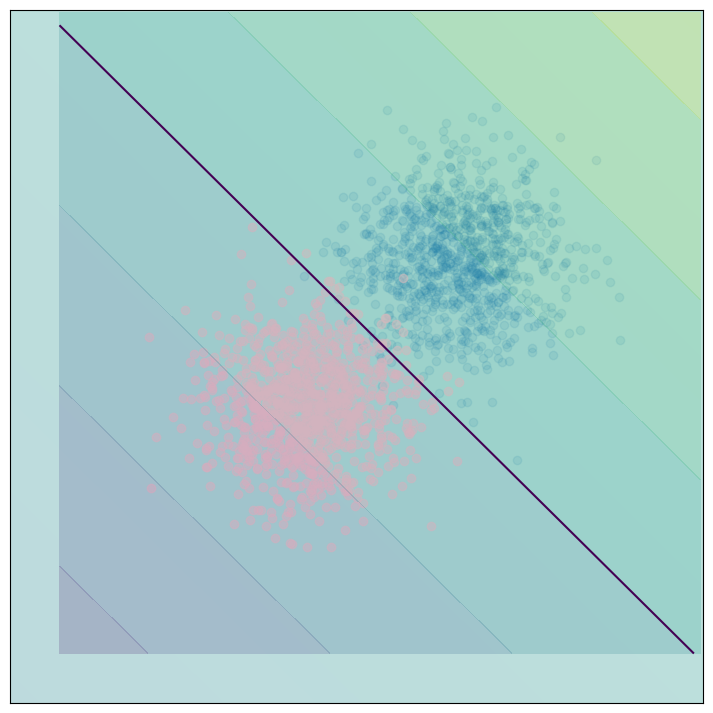

In [8]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
Xf = Xf.astype('float32')
Yf = Yf.astype('float32')
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==0
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

Z = model(test_data).numpy()
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-6,8,-6,8),alpha=0.3, vmin=-15, vmax=15)
plt.contourf(XX,YY,Z,alpha=0.2)
plt.contour(XX,YY,Z,[0.5])
fig = plt.gcf()
fig.set_size_inches(9,9)
plt.xticks([])  
plt.yticks([]);

## But... where this magic comes from? The flow of the chain rule

Let us try to understand visually what the chain rule is about. This will constitute the basis of the backpropagation algorithm, that will be next used to train deep learning techniques and the basis of **automatic differentiation**, a programatically optimum way for computing differentials.

### Computational graph

Consider the following function $f(x,y,z) = (x+y)\cdot z$. The computational graph corresponds to a graphical representation of the operations.

<img src = "files/comp_graph1.jpg"  width = "300">

Each of the archs can be labelled. This lets us to introduce a midpoint $q$.

Let us now look at the partial derivatives of each node with respect of its inputs. We have 

$$\frac{\partial f}{\partial f} = 1$$
$$\frac{\partial f}{\partial q} = z$$
$$\frac{\partial f}{\partial z} = q$$
$$\frac{\partial q}{\partial x} = 1$$
$$\frac{\partial q}{\partial y} = 1$$

Now, if we ask about the gradient with respect to any of the inputs, we can readily use the chain rule,

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial x} = z \cdot 1$$

$$\frac{\partial f}{\partial y} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial y} = z\cdot 1$$

$$\frac{\partial f}{\partial z} = q $$


This flow is the basic idea behind **automatic differentiation** or **algorithmic differentiation**. The idea is we can create a computational graph, and take advantage of this parsing to readily compute differentials (or store the operations involved) as we parse the graph. There are two flavours of automatic differentiation, **forward** and **backward**. Corresponding to two different views of operating using the chain rule, e.g. given the following chain

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial u}\frac{\partial u}{\partial x},$$

we can operate, from the start of the graph in a forward mode, this is

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \big(\frac{\partial q}{\partial u}\frac{\partial u}{\partial x}\big),$$

or backwards, starting from the end of the graph

$$\frac{\partial f}{\partial x} = \big(\frac{\partial f}{\partial q} \frac{\partial q}{\partial u}\big)\frac{\partial u}{\partial x}.$$

Forward autodiff is usually interesting when we are in front of a vectorial function and we need to compute its Jacobian, i.e. $$F(x) = (f_1(x),f_2(x), \dots, f_N(x))$$ and we want to compute the Jacobian $$\frac{\partial F}{\partial x} = (\frac{\partial f_1(x)}{\partial x},\dots, \frac{\partial f_N(x)}{\partial x})$$.

Backward differentiation is particularly useful when computing gradients, this is given a function $f(x_1,\dots,x_N)$, its gradient is $$\nabla f = (\frac{\partial f}{\partial x_1},\dots,\frac{\partial f}{\partial x_N}).$$



### A simple example for forward autodiff

Let us recall the previous problem

$$f = (x+y)z$$

and write a program that solves it:

In [9]:
# Program 
x = 5
y = 2
z = 3
q = x + y
f = q*z
print(f)

21


Let us now write a program that computes the gradient with respect 

In [10]:
# Differentiation Program 
dx = 0
dy = 1
dz = 0
dq = dx + dy
df = q*dz + z*dq
print(df)

3


Initializing $dx = 1$ and $dy=0$, $dz=0$ we are computing $df/dx$. Observe that we will get $df = z$. By initializing $dz = 1$ and the rest to zero we obtain $df = q$, this is $df = x+y$

**How would you automate that? What are the patters?** Overiding the operators and create in parallel both programs as we parse the computational graph.

## and now ... we are ready to start the class!

In standard usage of a deep learning framework we will even operate at a higher level. Let us now change this to an operational code.

In [11]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1, activation=None)
])

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

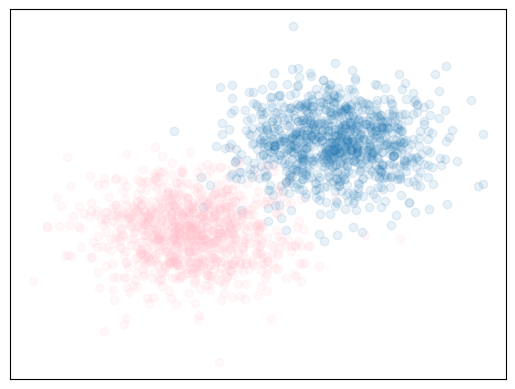

In [12]:
#Example dataset
N_samples_per_class = 1000
d_dimensions = 2
x = np.vstack((np.random.randn(N_samples_per_class, d_dimensions),np.random.randn(N_samples_per_class, d_dimensions)+np.array([3,3])))
y = np.vstack((np.zeros((N_samples_per_class,1)),1.*np.ones((N_samples_per_class,1))))

x = x.astype('float32')
y = y.astype('float32')

%matplotlib inline

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==0
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1,color='pink')
plt.xticks([])  
plt.yticks([]);

In [13]:
model.fit(x, y, epochs=1, batch_size = 1)

2000/2000 [==============================] - 2s 939us/step - loss: 0.0699 - accuracy: 0.9700


In [14]:
model.evaluate(x,  y, verbose=2)

63/63 - 8s - loss: 0.0448 - accuracy: 0.9805 - 8s/epoch - 124ms/step


[0.04476721212267876, 0.9804999828338623]

In [15]:
np.where(model.predict(x)>0.5,1.,-1.)

array([[ 1.],
       [-1.],
       [-1.],
       ...,
       [ 1.],
       [ 1.],
       [ 1.]])

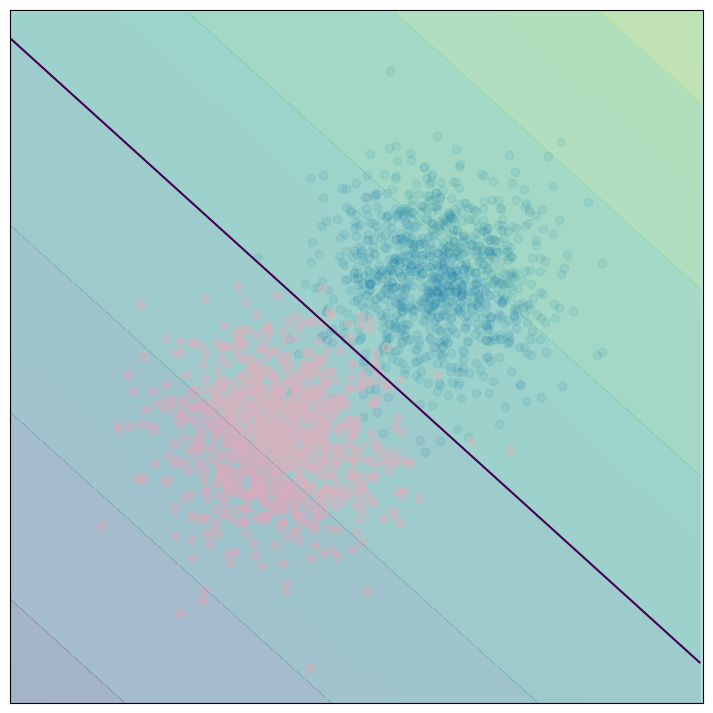

In [16]:
delta = 0.05
xx = np.arange(-5.0, 8.0, delta)
yy = np.arange(-5.0, 8.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
test_data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1);

idx = y==1
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.1)
idx = y==0
plt.scatter(x[idx.ravel(),0],x[idx.ravel(),1],alpha=0.5,color='pink')

Z = model.predict(test_data)
Z.shape=sz

plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-5,8,-5,8),alpha=0.3, vmin=-15, vmax=15)
plt.contourf(XX,YY,Z,alpha=0.2)
plt.contour(XX,YY,Z,[0.5])
fig = plt.gcf()
fig.set_size_inches(9,9)
plt.xticks([])  
plt.yticks([]);